In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebPQC
from squlearn.expectation_operator import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss, VarianceLoss, get_variance_fac
from squlearn.optimizers import Adam

In [2]:
executor = Executor("statevector_simulator")

Define parameterized quantum circuit $Q(x,\theta)$

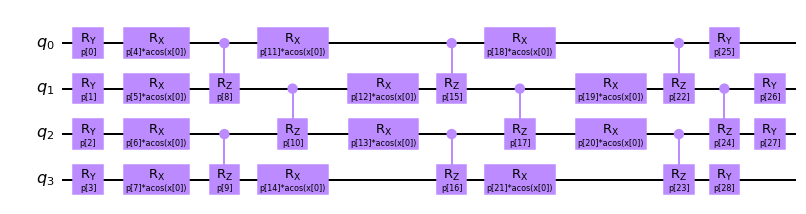

In [3]:
nqubits = 4
number_of_layers = 3
pqc = ChebPQC(nqubits, 1, num_layers=number_of_layers, closed=False)
pqc.draw()

Definition of the cost operator:
$\hat{C}(\vartheta) = \vartheta_0 \hat{I} + \sum_i \vartheta_i \hat{Z}_i $

In [4]:
cost_op = SummedPaulis(nqubits)
print(cost_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])


Example function: $log(x)$

In [5]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)

np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters) * 4
param_op_ini = np.ones(cost_op.num_parameters)

Optimization of the regression

In [6]:
ADAM = Adam({"maxiter_total": 100, "maxiter": 25, "lr": 0.1, "log_file": "adam_log.csv"})

reg = QNNRegressor(
    pqc,
    cost_op,
    executor,
    SquaredLoss(),
    ADAM,
    param_ini,
    param_op_ini,
    variance=get_variance_fac(0.005, 0.5, 5),
)

reg.fit(x_space, ref_values)

theta [3.11080964 0.95016488 3.29711413 3.86299679 3.89040446 1.81379699
 2.43616985 3.10210606 2.56645338 2.88807292 0.1401461  1.19379788
 0.23404997 3.42824377 1.49141611 2.71939181 1.0251198  1.39032486
 0.03765108 1.43333513 3.79637673 0.87159604 1.27756547 3.67108954
 0.12761467 0.26033815 2.519316   3.49525377 0.03486293 1.
 1.         1.         1.         1.        ]
Current value: 56.394715291045124
theta [3.11080964 0.95016488 3.29711413 3.86299679 3.89040446 1.81379699
 2.43616985 3.10210606 2.56645338 2.88807292 0.1401461  1.19379788
 0.23404997 3.42824377 1.49141611 2.71939181 1.0251198  1.39032486
 0.03765108 1.43333513 3.79637673 0.87159604 1.27756547 3.67108954
 0.12761467 0.26033815 2.519316   3.49525377 0.03486293 1.
 1.         1.         1.         1.        ]
Grad length: 63.9537044289369
grad [  0.52348418   2.60030605  -1.43284283  -1.59848242   6.05881838
   1.05112679 -13.48612921  12.00088504  12.7947583    1.11221222
  -2.73168141  -1.52007302  -5.76641424 -

In [7]:
reg.set_params(variance=get_variance_fac(0.005, 0.5, 5, offset=ADAM.iteration))
reg.partial_fit(x_space, ref_values)

theta [ 1.95298843  1.8692434   2.45183371  3.54459277  2.97691132  0.16972455
  2.69545847  2.06347475  1.59407161  2.385522    0.65556835  1.08977929
  0.43418123  3.35490121  0.87505652  2.02907341  1.23783349  2.15370544
 -0.94735206  1.89104315  2.62407527  1.07963002  0.66348406  2.76326316
  0.66474324  1.17241606  1.77517219  2.71349385  0.27682367 -0.53285805
  0.36025379  0.46420681 -0.23889801  0.87466231]
Current value: 0.37899543175258776
theta [ 1.95298843  1.8692434   2.45183371  3.54459277  2.97691132  0.16972455
  2.69545847  2.06347475  1.59407161  2.385522    0.65556835  1.08977929
  0.43418123  3.35490121  0.87505652  2.02907341  1.23783349  2.15370544
 -0.94735206  1.89104315  2.62407527  1.07963002  0.66348406  2.76326316
  0.66474324  1.17241606  1.77517219  2.71349385  0.27682367 -0.53285805
  0.36025379  0.46420681 -0.23889801  0.87466231]
Grad length: 1.683381755745998
grad [ 0.0064269  -0.38689054  0.22708702  0.19662105  0.03530188  0.01877463
  0.15916649 -

In [8]:
reg.set_params(variance=get_variance_fac(0.005, 0.5, 5, offset=ADAM.iteration))
reg.partial_fit(x_space, ref_values)

theta [ 1.85864558  2.40076555  2.16467602  3.3546674   2.95340035 -0.25131017
  2.61520484  1.95462771  1.53564032  2.14224606  0.40873856  0.94635988
  0.28752893  3.06449968  0.79523728  2.01949843  1.23289095  2.32095989
 -1.02290872  1.87518783  2.36921484  1.1406508   0.48471792  2.61125097
  0.41732844  1.22931963  1.91220113  2.61020691 -0.13337391 -0.66023726
  0.50587425  0.42831288 -0.29429597  0.7918703 ]
Current value: 0.11161426986382986
theta [ 1.85864558  2.40076555  2.16467602  3.3546674   2.95340035 -0.25131017
  2.61520484  1.95462771  1.53564032  2.14224606  0.40873856  0.94635988
  0.28752893  3.06449968  0.79523728  2.01949843  1.23289095  2.32095989
 -1.02290872  1.87518783  2.36921484  1.1406508   0.48471792  2.61125097
  0.41732844  1.22931963  1.91220113  2.61020691 -0.13337391 -0.66023726
  0.50587425  0.42831288 -0.29429597  0.7918703 ]
Grad length: 0.5142241522620359
grad [ 0.02091997  0.06354431 -0.17211613  0.13792632 -0.0036419   0.00173493
  0.04113798 

In [9]:
reg.set_params(variance=get_variance_fac(0.005, 0.5, 5, offset=ADAM.iteration))
reg.partial_fit(x_space, ref_values)

theta [ 2.02892481  2.41314433  2.29191534  3.30148067  2.95384282 -0.47565824
  2.60238755  1.91671954  1.5468213   1.92740118  0.37863131  1.06483539
  0.34022187  3.02347393  0.73332877  2.00063728  1.38171715  2.33064224
 -1.0241354   1.94045476  2.29353014  1.14821404  0.6367382   2.63237058
  0.61106875  1.21910375  1.94733491  2.59805342 -0.19674736 -0.6803016
  0.54331957  0.4982141  -0.36536771  0.75580924]
Current value: 0.05933035432412016
theta [ 2.02892481  2.41314433  2.29191534  3.30148067  2.95384282 -0.47565824
  2.60238755  1.91671954  1.5468213   1.92740118  0.37863131  1.06483539
  0.34022187  3.02347393  0.73332877  2.00063728  1.38171715  2.33064224
 -1.0241354   1.94045476  2.29353014  1.14821404  0.6367382   2.63237058
  0.61106875  1.21910375  1.94733491  2.59805342 -0.19674736 -0.6803016
  0.54331957  0.4982141  -0.36536771  0.75580924]
Grad length: 0.18293442268717713
grad [-0.00782773  0.02333376 -0.06077055  0.04993472 -0.00038514  0.00535291
  0.01759074  

In [10]:
print("Result Param:", reg.param)
print("Result ParamOp:", reg.param_op)

Result Param: [ 2.14072305  2.41188367  2.36246405  3.29045553  2.94550894 -0.53457555
  2.60881096  1.92270585  1.562211    1.82635782  0.37142308  1.10269349
  0.3627689   3.02851541  0.72523964  1.98997442  1.43337714  2.31838183
 -1.01909566  1.9604151   2.27963538  1.18195303  0.68919935  2.65531773
  0.70353443  1.18626751  1.92877923  2.5931212  -0.2002607 ]
Result ParamOp: [-0.688705    0.54255727  0.51404578 -0.39663934  0.71535574]


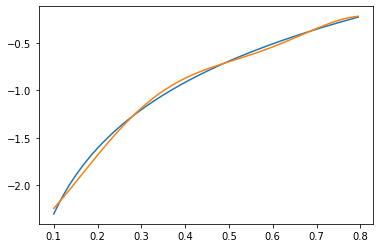

In [11]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)